In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris, load_breast_cancer, load_wine
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from statistics import stdev, mean

import sys  
sys.path.insert(0, 'C:\\python_projects\\ikNN_project\\ikNN')
from interpretable_knn import ikNNClassifier

## Methods to load sklearn toy datasets

In [3]:
# This cell provides methods to test with 3 of the toy datasets provided by sklearn. 
# For consistency, we load each X as a pandas dataframe and y as a numpy array.

def get_iris():
    iris = load_iris()
    X, y = iris.data, iris.target
    X = pd.DataFrame(X, columns=iris['feature_names'])
    return X, y

def get_breast_cancer():
    X, y = load_breast_cancer(return_X_y=True, as_frame=True)
    return X, y.values

def get_wine():
    X, y = load_wine(return_X_y=True, as_frame=True)
    return X, y.values

## Example running both sklearn's kNN and interpretable_knn on the toy datasets

In [13]:
# Here we test sklearn's kNN as well as interpretable_knn in terms of accuracy. 
# In both cases, the default hyperparameters are used. This provides a simple 
# example where the accuracy of interpretable_knn is comparable to sklearn's
# kNN and often higher. In this case, kNN does better 2 out of the 3 times and
# ikNN does better (though significantly better) one of the 3. 

def test_classification(X, y):
    
    def test_sklearn_knn(): 
        print("kNN")
        clf = KNeighborsClassifier()
        scores = cross_validate(clf, X, y, cv=5, scoring='f1_macro', return_train_score=True)
        return scores
    
    def test_2d_knn():       
        print("\nikNN")
        clf = ikNNClassifier()
        scores = cross_validate(clf, X, y, cv=5, scoring='f1_macro', return_train_score=True)
        return scores
    
    def print_scores(scores):    
        train_scores = scores['train_score']
        test_scores = scores['test_score']
        avg_train_score = mean(train_scores)
        avg_test_score = mean(test_scores)
        scores_std_dev = stdev(test_scores)

        print("Average f1 score on training data: ", round(avg_train_score,3))
        print("Average f1 score on test data:     ", round(avg_test_score,3))
        print("Std dev of f1 scores on test data: ", round(scores_std_dev,3))
        
    print_scores(test_sklearn_knn())
    print_scores(test_2d_knn())

# Given a method to load a dataset, load the dataset and test the accuracy of a sklearn decision tree with and without
# the extended features.
def test_dataset(load_method, file_name):
    print("\n\n*********************************************")
    print("Calling for " + file_name)
    print("*********************************************")
    
    X, y = load_method()
    test_classification(X, y)
    
test_dataset(get_iris, "Iris")
test_dataset(get_breast_cancer, "Breast Cancer")
test_dataset(get_wine, "Wine")



*********************************************
Calling for Iris
*********************************************
kNN
Average f1 score on training data:  0.97
Average f1 score on test data:      0.973
Std dev of f1 scores on test data:  0.028

ikNN
Average f1 score on training data:  0.967
Average f1 score on test data:      0.96
Std dev of f1 scores on test data:  0.028


*********************************************
Calling for Breast Cancer
*********************************************
kNN
Average f1 score on training data:  0.943
Average f1 score on test data:      0.922
Std dev of f1 scores on test data:  0.028

ikNN
Average f1 score on training data:  0.942
Average f1 score on test data:      0.912
Std dev of f1 scores on test data:  0.033


*********************************************
Calling for Wine
*********************************************
kNN
Average f1 score on training data:  0.772
Average f1 score on test data:      0.671
Std dev of f1 scores on test data:  0.052

ikNN


## Example Visualizing the model

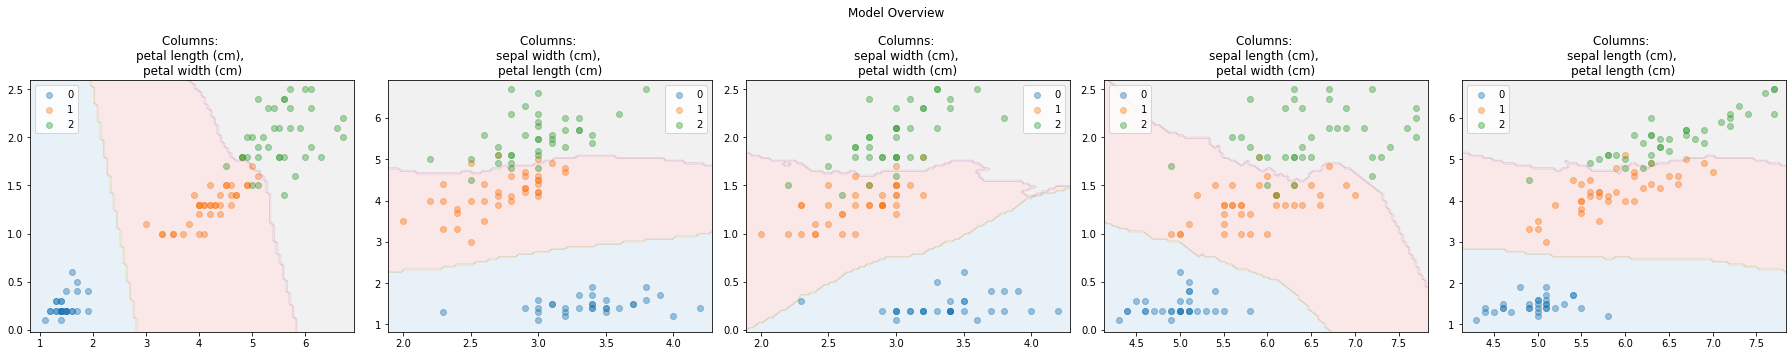

In [5]:
# This provides an example calling graph_model() to get an overview
# of the data and the model. By default, this shows five 2D subspaces. 

X, y = get_iris()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ikNN = ikNNClassifier()
ikNN.fit(X_train, y_train)
ikNN.graph_model(X.columns)

# Example Visualizing Individual Predictions



*********************************************
Calling for Iris
*********************************************
Rows predicted incorrectly:  []


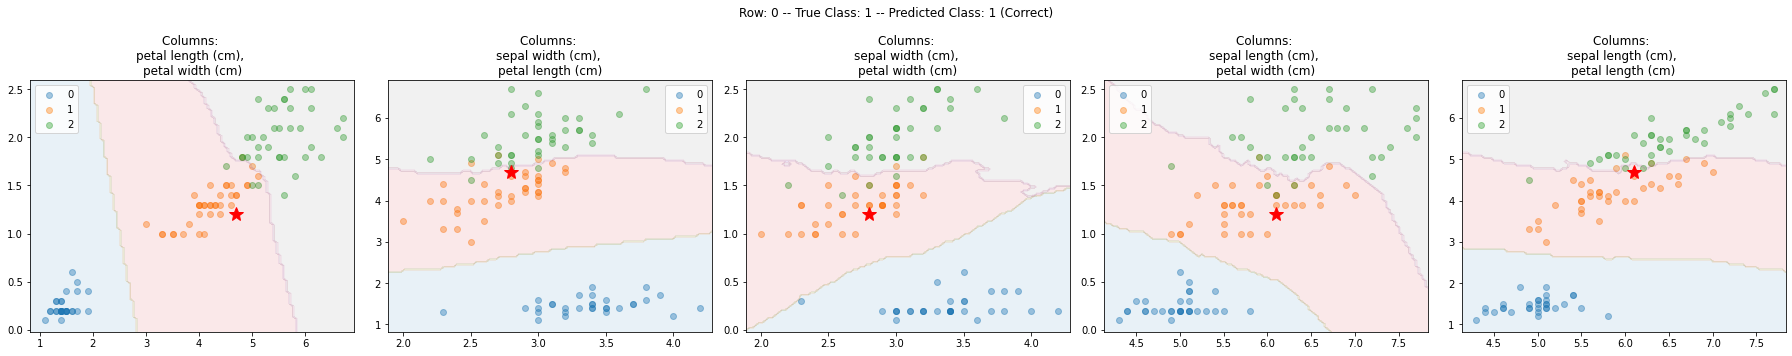

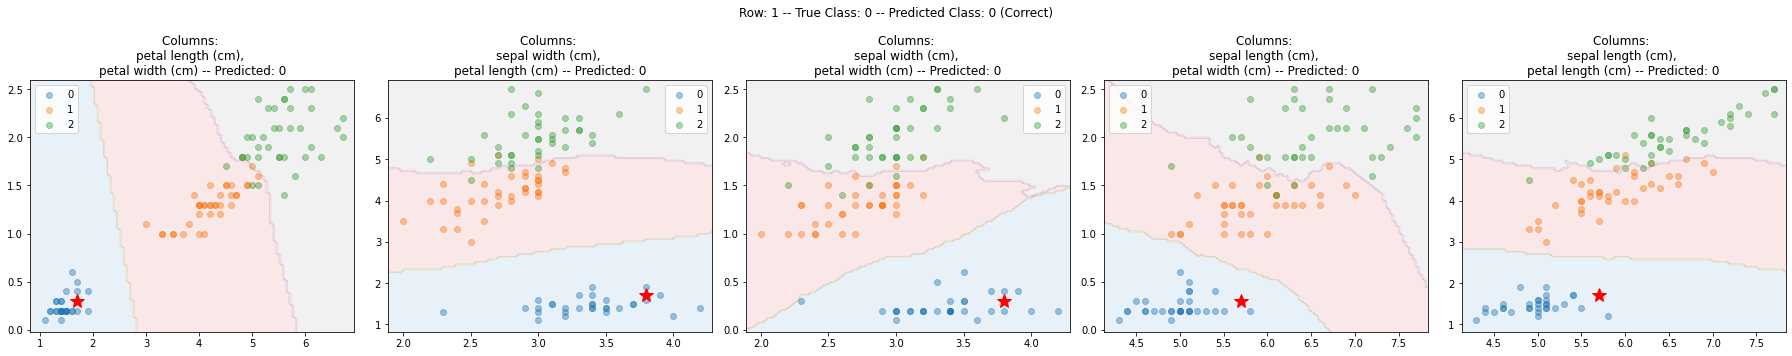

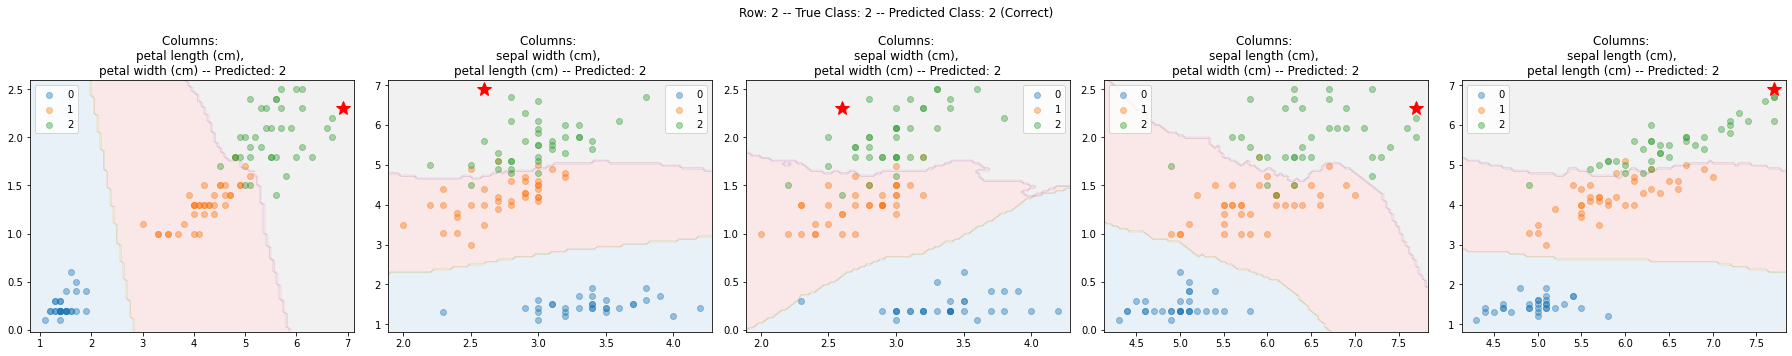

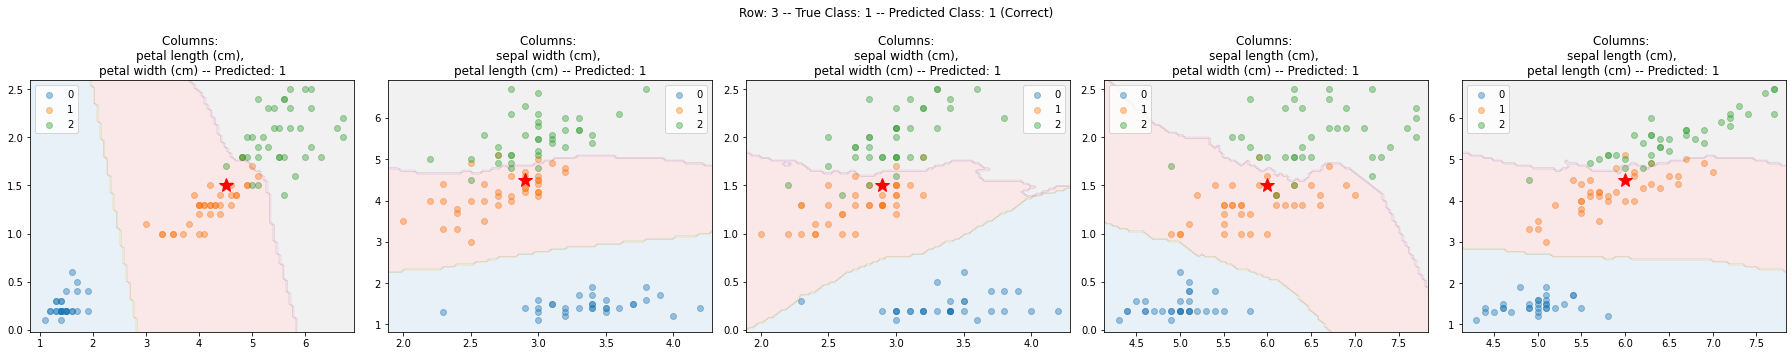

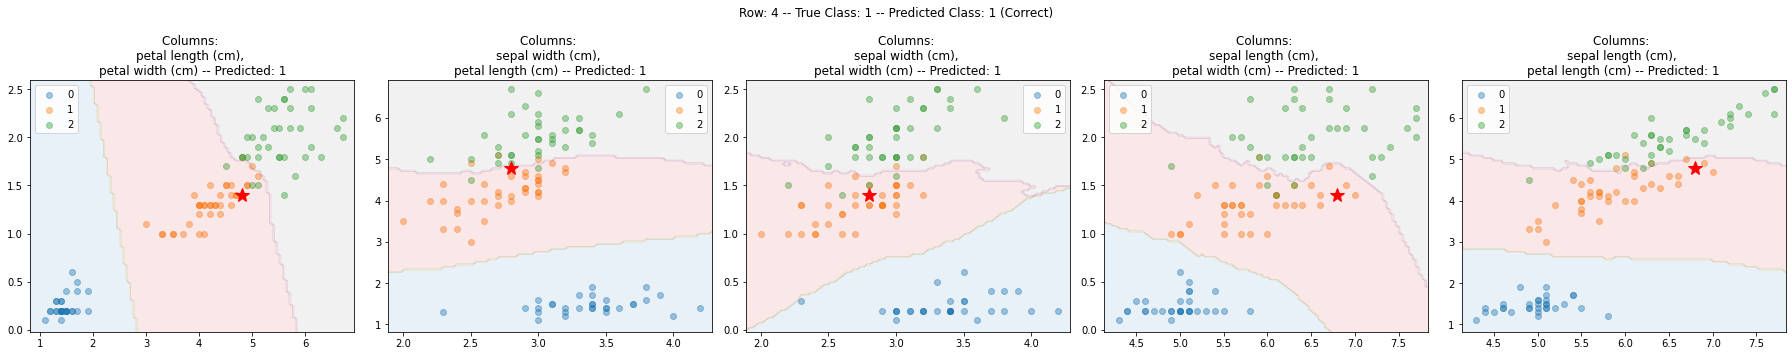



*********************************************
Calling for Breast Cancer
*********************************************
Rows predicted incorrectly:  [8, 36, 82, 108, 114, 138, 148, 150, 164, 170]


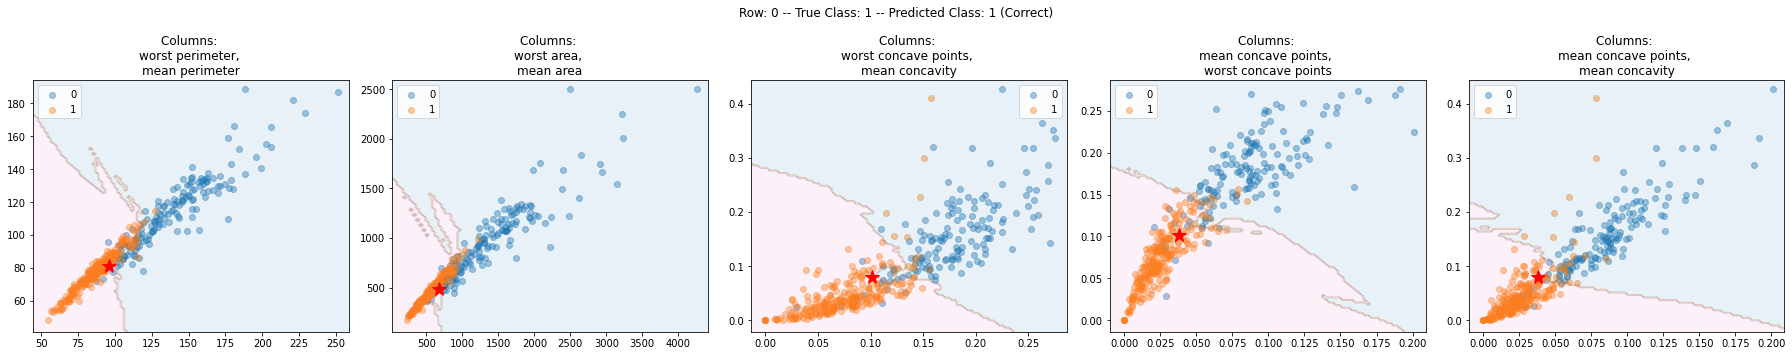

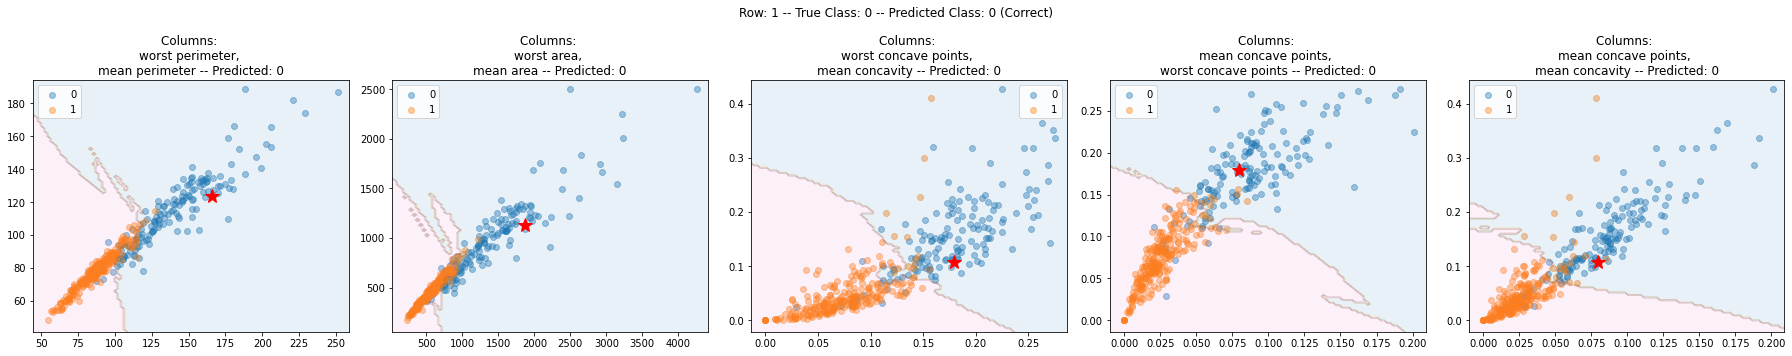

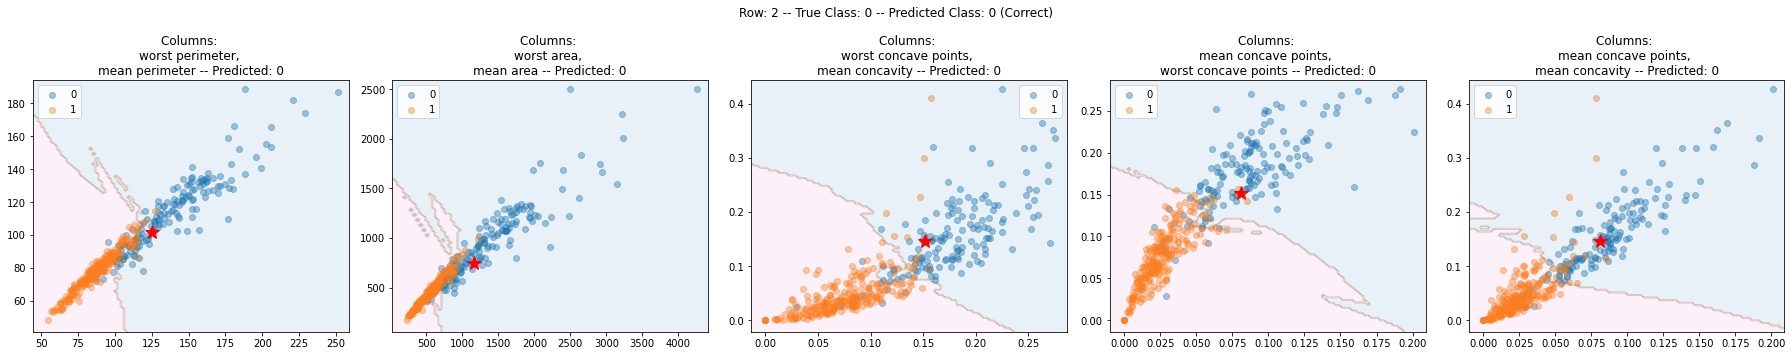

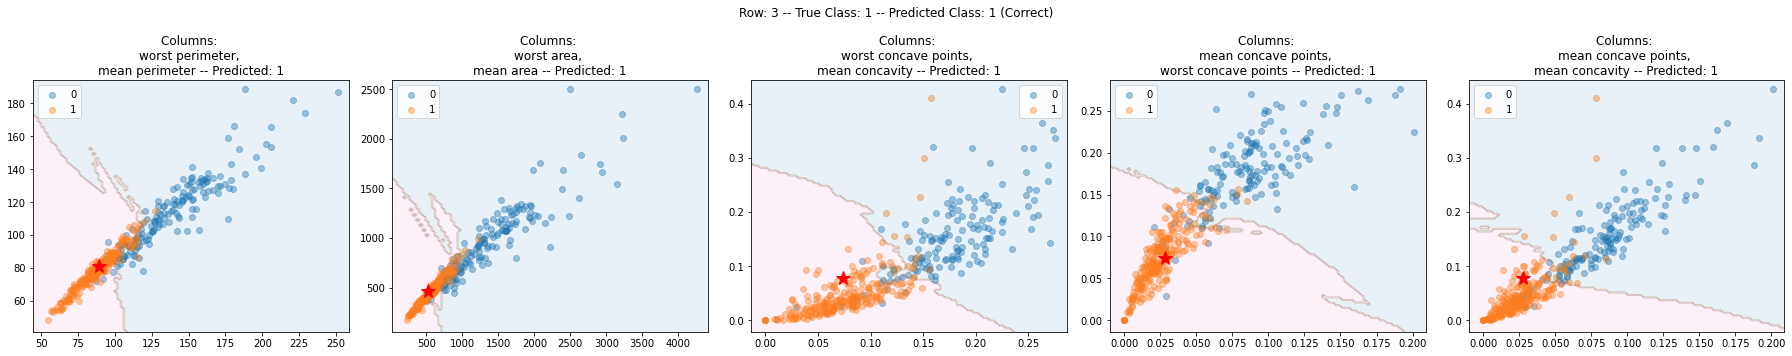

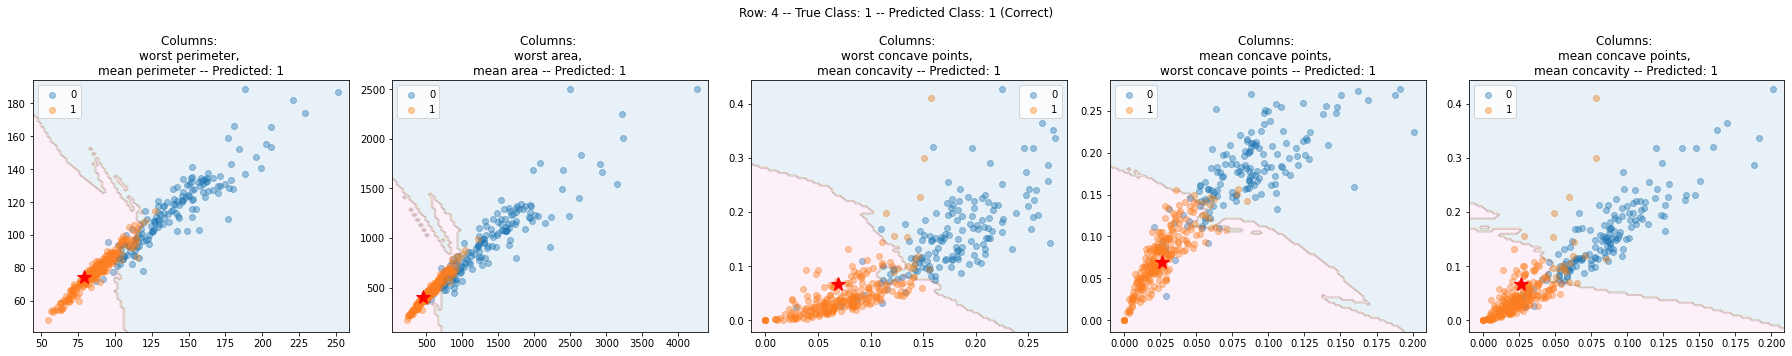



*********************************************
Calling for Wine
*********************************************
Rows predicted incorrectly:  [4, 21, 27, 38, 50]


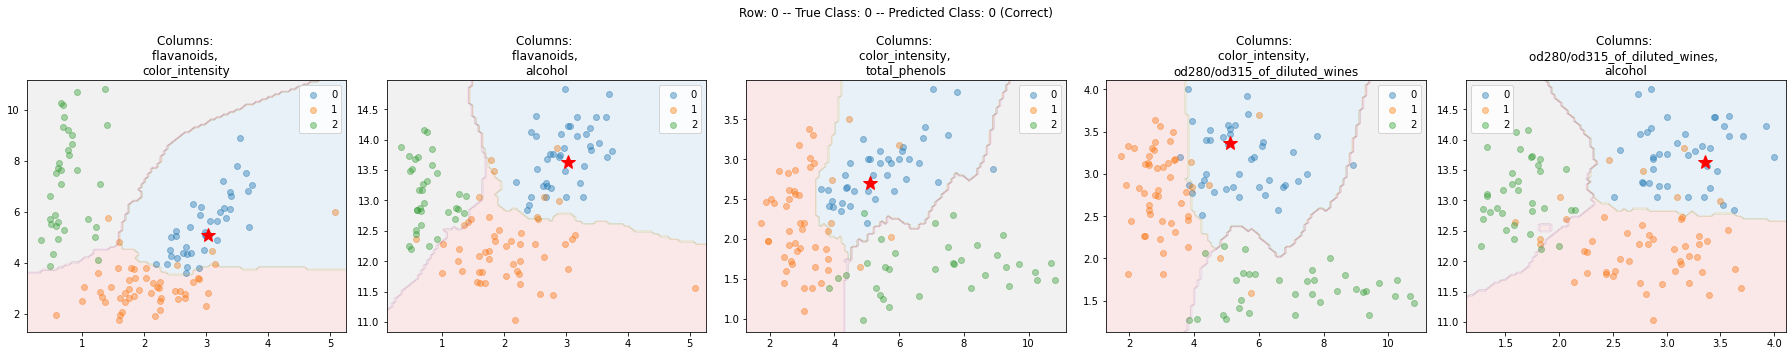

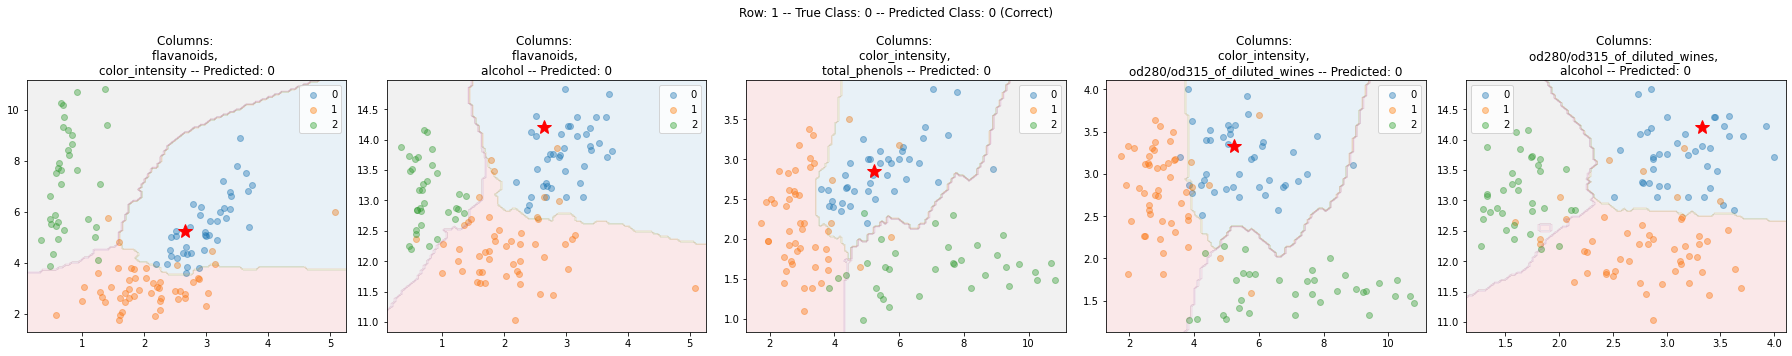

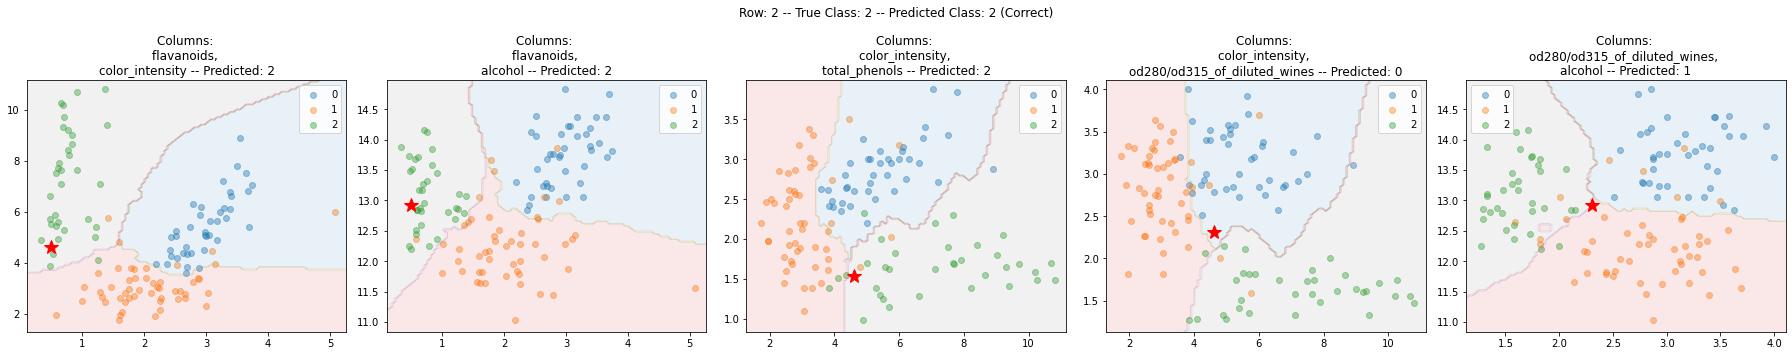

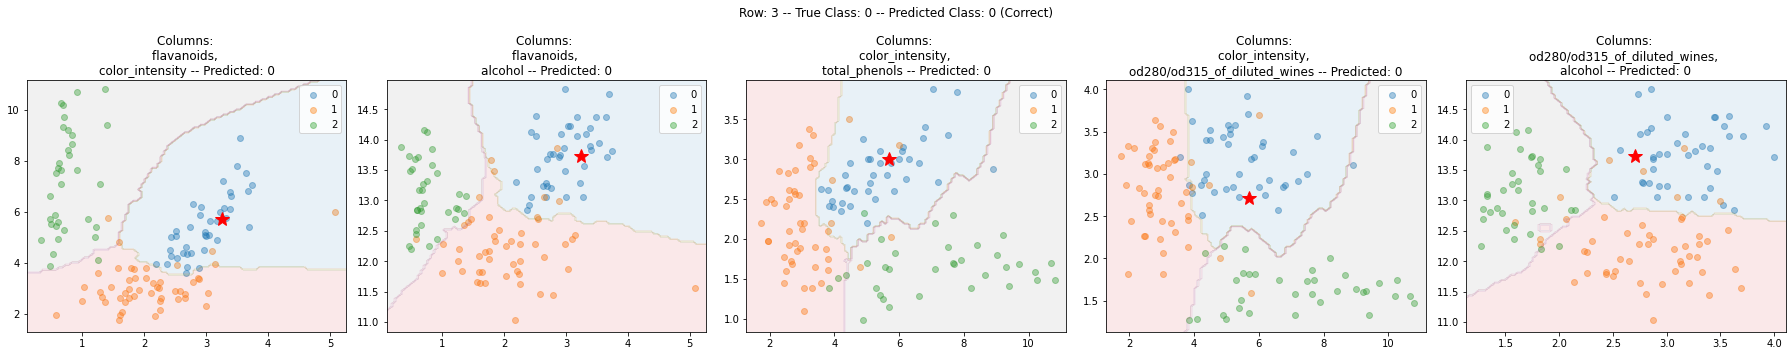

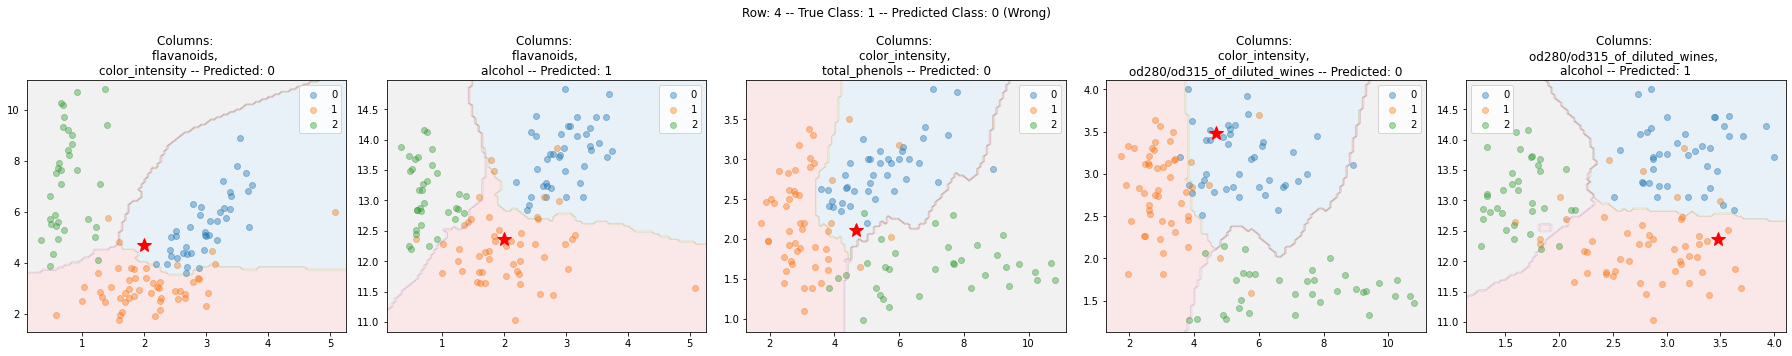

In [6]:
# Note: this uses a train-test split, and the accuracy may vary 
# from the cross-validated executions above. 
# This presents five rows for each of 3 datasets. 
# For each row, five 2d spaces are shown. 

def visualize_models(load_method, file_name, num_rows_visualized=5):
    print("\n\n*********************************************")
    print("Calling for " + file_name)
    print("*********************************************")
    
    X, y = load_method()
    
    # Create an interpretable_knn to use for visualization
    ikNN = ikNNClassifier()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    ikNN.fit(X_train, y_train)        
    pred_y_train = ikNN.predict(X_train)
    pred_y_test = ikNN.predict(X_test)
    
    wrong_rows = []
    for i in range(len(y_test)):
        if (pred_y_test[i] != y_test[i]):
            wrong_rows.append(i)
    print("Rows predicted incorrectly: ", wrong_rows)

    num_rows_visualized = min(num_rows_visualized, len(X))
    for i in range(num_rows_visualized):
        ikNN.graph_predictions(X_test.iloc[i], i, y_test[i:i+1][0], X.columns)

visualize_models(get_iris, "Iris")
visualize_models(get_breast_cancer, "Breast Cancer")
visualize_models(get_wine, "Wine")

## Example using a Grid Search to Optimize sklearn's kNN Classifier

In [7]:
iris = load_iris()
parameters = {'n_neighbors':(1,10,50), 'metric':('euclidean','manhattan') }
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters)
clf.fit(iris.data, iris.target)
s = clf.score(iris.data, iris.target)
print("score: ", s)
b = clf.best_estimator_
print("best hyperparameters: ", b)
print("params: ", b.get_params())

score:  0.98
best hyperparameters:  KNeighborsClassifier(metric='euclidean', n_neighbors=10)
params:  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}


## Example using a Grid Search to Optimize interpretableKNN

In [8]:
# Note: this may take several minutes to execute.

def grid_search(X,y):
    parameters = { 'n_neighbors':(1, 2, 3, 4, 5, 10, 20), 
                    'method': ('simple majority', 'use proba'),
                    'weight_by_score': (True, False),
                    'num_best_spaces': (-1, 1, 2, 3, 4, 5, 10, 20)
                 }
    iknn = ikNNClassifier()
    clf2 = GridSearchCV(iknn, parameters, scoring='f1_macro')
    clf2.fit(X, y)
    s = clf2.score(X,y)
    print("score: ", s)
    b = clf2.best_estimator_
    print("best hyperparameters: ", b)

iris = load_iris()    
grid_search(iris.data, iris.target)

score:  0.9533286661999533
best hyperparameters:  ikNNClassifier(n_neighbors=20, num_best_spaces=4, weight_by_score=False)


# Example using ArithemeticFeatures

In [10]:
# ikNN can take advantage of engineered features such as those produced
# by ArithmeticFeatures in a more robust manner than many predictors, as
# it uses only two features per subspace, and takes only the strongest 
# of these. 

import sys  
sys.path.insert(0, 'C:\python_projects\ArithmeticFeatures_project\ArithmeticFeatures')
from ArithmeticFeatures import ArithmeticFeatures

X, y = get_iris()
clf = ikNNClassifier()
scores = cross_validate(clf, X, y, cv=5, scoring='f1_macro', return_train_score=True)
print("Scores using the original features:", scores['test_score'])

arith = ArithmeticFeatures()
extended_X = pd.DataFrame(arith.fit_transform(X), columns=arith.get_feature_names())
clf = ikNNClassifier()
scores = cross_validate(clf, extended_X, y, cv=5, scoring='f1_macro', return_train_score=True)
print("Scores using the extended features:", scores['test_score'])

Scores using the original features: [0.96658312 0.96658312 0.93265993 0.93333333 1.        ]
Scores using the extended features: [0.96658312 1.         0.93265993 0.93333333 1.        ]


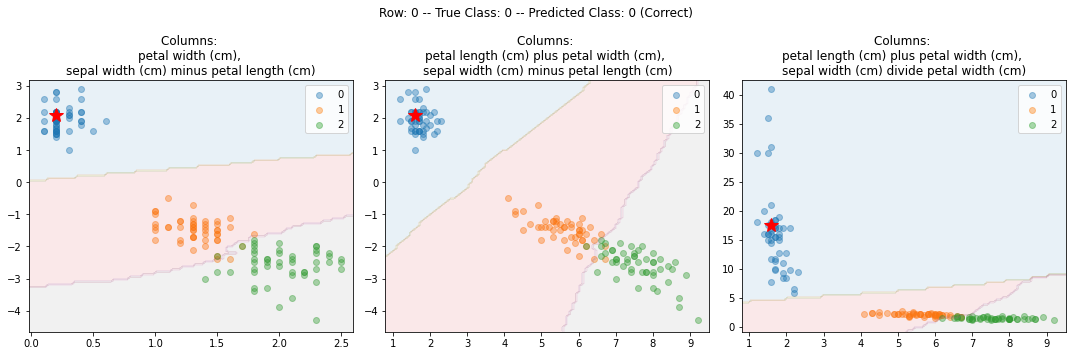

In [12]:
row_num = 0
clf = ikNNClassifier()
clf.fit(extended_X, y)
clf.predict(extended_X)
clf.graph_predictions(extended_X.loc[row_num], row_num, y[row_num], extended_X.columns, num_spaces_shown=3)